# Group Project 4

imports 

In [477]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


read in EPA air_quality .csv files

In [495]:
# # read in each CSV file in air_quality_data directory and concatenate them into one dataframe
air_quality_data = pd.concat([pd.read_csv('air_quality_data/{}'.format(file)) for file in os.listdir('air_quality_data')])

# daily air quality data
air_quality_data_daily = pd.concat([pd.read_csv('daily_air_quality_data/{}'.format(file), low_memory=False) for file in os.listdir('daily_air_quality_data')])

# life expectancy data by CA county
life_expectancy = pd.read_csv('health_data/Vital_Signs_Life_Expectancy_by_county.csv')

# mortality tables for CA counties from 2014-2022
mortality = pd.read_csv('health_data/mortality.csv')

# mortality tables for CA counties from 1999-2013
mortality_2 = pd.read_csv('health_data/99-13_mortality.csv')

# concatenate the two mortality tables
mortality = pd.concat([mortality, mortality_2]).sort_values(by='Year').reset_index(drop=True)

# monthly mortality data 

mortality_data_monthly = pd.concat([pd.read_csv('monthly_health_data/{}'.format(file)) for file in os.listdir('monthly_health_data')])

# 5 year cancer incidence rates by CA county
cancer_incidence = pd.read_csv('health_data/incd.csv')

In [526]:
# write air_quality_data_daily to sql database for use in other notebooks

from sqlalchemy import create_engine

# sql alchemy engine
engine = create_engine('sqlite:///air_quality_data_daily.db', echo=False)
air_quality_data_daily.to_sql('air_quality_data_daily', con=engine, if_exists='replace', index=False)


7296330

In [479]:
# clean cancer incidence data

# remove (7) from every county name
cancer_incidence['County'] = cancer_incidence['County'].str.replace(r'\(.*\)', '', regex=True).str.strip()

# remove "County" from every county name
cancer_incidence['County'] = cancer_incidence['County'].str.replace('County', '', regex=False).str.strip()

# filter for only counties in ca_df['County].unique()
cancer_incidence = cancer_incidence[cancer_incidence['County'].isin(air_quality_data['County'].unique())]

# add 2019 as year
cancer_incidence['Year'] = 2019

Filter `air_quality_data` down to only California

In [496]:
# filter for only California 
ca_df = air_quality_data.query('State == "California"').copy()

# Set the index to be the year
ca_df.set_index('Year', inplace=True)

# annual air quality data
ca_df = ca_df.query('`Days with AQI` > 360').copy()

# daily air quality data
ca_df_daily = air_quality_data_daily.query('`State Name` == "California"').copy()
ca_df_daily.set_index(pd.to_datetime(ca_df_daily['Date']), inplace=True)
# datetime index

# daily to monthly
ca_df_daily = ca_df_daily.groupby('county Name').resample('MS').mean()

# rename index to 'County'
ca_df_daily.index.rename('County', level=0, inplace=True)

In [517]:
ca_df_daily

County Code        AQI  Number of Sites Reporting
County  Date                                                         
Alameda 1999-01-01          1.0  43.451613                   3.000000
        1999-02-01          1.0  42.500000                   3.000000
        1999-03-01          1.0  38.258065                   3.000000
        1999-04-01          1.0  49.933333                   5.000000
        1999-05-01          1.0  40.387097                   5.000000
...                         ...        ...                        ...
Yolo    2022-05-01        113.0  40.000000                   2.161290
        2022-06-01        113.0  42.966667                   2.166667
        2022-07-01        113.0  39.956522                   1.217391
        2022-08-01        113.0  46.500000                   1.200000
        2022-09-01        113.0  50.133333                   1.000000

[15149 rows x 3 columns]

DateTime Index for Monthly Mortality Data

In [515]:
# combine Year and Month columns into a single column, then convert to datetime object and set as index

mortality_data_monthly['Year'] = mortality_data_monthly['Year'].astype(str)
mortality_data_monthly['Month'] = mortality_data_monthly['Month'].astype(str)
mortality_data_monthly['Date'] = mortality_data_monthly['Year'] + '-' + mortality_data_monthly['Month'] + '-01'
mortality_data_monthly['Date'] = pd.to_datetime(mortality_data_monthly['Date'])
mortality_data_monthly.set_index('Date', inplace=True)

# drop Year and Month columns
mortality_data_monthly.drop(['Year', 'Month'], axis=1, inplace=True)

In [516]:
mortality_data_monthly

,County,Geography_Type,Strata,Strata_Name,Cause,Cause_Desc,Count,Annotation_Code,Annotation_Desc,ICD_Revision,Data_Revision_Date
Date,,,,,,,,,,,
1999-01-01,Alameda,Residence,Total Population,Total Population,ALL,All causes (total),956.0,NaN,NaN,NaN,NaN
1999-01-01,Alameda,Residence,Age,Under 1 year,ALL,All causes (total),NaN,1.0,Cell suppressed for small numbers,NaN,NaN
1999-01-01,Alameda,Residence,Age,1-4 years,ALL,All causes (total),NaN,1.0,Cell suppressed for small numbers,NaN,NaN
1999-01-01,Alameda,Residence,Age,5-14 years,ALL,All causes (total),NaN,1.0,Cell suppressed for small numbers,NaN,NaN
1999-01-01,Alameda,Residence,Age,15-24 years,ALL,All causes (total),11.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,Yuba,Residence,Race-Ethnicity,Hawaiian/Pacific Islander,SUI,Intentional self-harm (suicide),0.0,NaN,NaN,ICD-10,12/15/2022
2021-12-01,Yuba,Residence,Race-Ethnicity,Hispanic,SUI,Intentional self-harm (suicide),0.0,NaN,NaN,ICD-10,12/15/2022
2021-12-01,Yuba,Residence,Race-Ethnicity,Multi-Race,SUI,Intentional self-harm (suicide),0.0,NaN,NaN,ICD-10,12/15/2022


# CA Mortality Statistics

| Abbreviation | Cause of Death |
| --- | --- |
| ALL | All causes (total) |
| ALZ | Alzheimer's disease [G30] |
| CAN | Malignant neoplasms (cancers) [C00-C97] |
| CLD | Chronic lower respiratory disease (CLRD) [J40-J47] |
| DIA | Diabetes mellitus [E10-E14] |
| HOM | Assault (homicide) [*U01-*U02, X85-Y09, Y87.1] |
| HTD | Diseases of heart [I00-I09, I11, I13, I20-I51] |
| HYP | Essential hypertension and hypertensive renal disease [I10, I12, I15] |
| INJ | Accidents (unintentional injuries) [V01-X59, Y85-Y86] |
| LIV | Chronic liver disease and cirrhosis [K70, K73-K74] |
| NEP | Nephritis, nephrotic syndrome and nephrosis [N00-N07, N17-N19, N25-N27] |
| PAR | Parkinson's disease [G20-G21] |
| PNF | Pneumonia and influenza [J09-J18] |
| STK | Cerebrovascular disease (stroke) [I60-I69] |
| SUI | Intentional self-harm (suicide) [*U03, X60-X84, Y87.0] |


# Annual and Monthly DataFrames for 4 major Mortalities

In [482]:
# deaths likely attributable to air pollution
respiratory_diseases = ['CLD', 'CAN', 'PNF', 'HTD']

In [483]:
# create a df for each disease

# chronic lower respiratory diseases
cld = mortality.query('Cause == "CLD" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

cld_monthly = mortality_data_monthly.query('Cause == "CLD" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

# cancer
can = mortality.query('Cause == "CAN" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

can_monthly = mortality_data_monthly.query('Cause == "CAN" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

# pneumonia
pneumonia = mortality.query('Cause == "PNF" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

pneumonia_monthly = mortality_data_monthly.query('Cause == "PNF" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

# heart disease
heart_disease = mortality.query('Cause == "HTD" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

heart_disease_monthly = mortality_data_monthly.query('Cause == "HTD" and Strata == "Total Population" and Geography_Type == "Residence"').copy()


# Merge with EPA DATA

In [501]:
# only want full data
ca_df = ca_df.query('`Days with AQI` > 360').copy()

# merge cld and ca_df
cld = cld.merge(ca_df, how='left', left_on=['County', 'Year'], right_on=['County', 'Year'])

cld_monthly = cld_monthly.merge(ca_df_daily, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])

# merge can and ca_df
can = can.merge(ca_df, how='left', left_on=['County', 'Year'], right_on=['County', 'Year'])

can_monthly = can_monthly.merge(ca_df_daily, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])

# merge pneumonia and ca_df
pneumonia = pneumonia.merge(ca_df, how='left', left_on=['County', 'Year'], right_on=['County', 'Year'])

pneumonia_monthly = pneumonia_monthly.merge(ca_df_daily, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])

# merge heart_disease and ca_df
heart_disease = heart_disease.merge(ca_df, how='left', left_on=['County', 'Year'], right_on=['County', 'Year'])

heart_disease_monthly = heart_disease_monthly.merge(ca_df_daily, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])

# query dataframes so count is greater than 0

# chronic 
cld = cld.query('Count > 0')

# cancer
can = can.query('Count > 0')

# pneumonia
pneumonia = pneumonia.query('Count > 0')

# heart disease
heart_disease = heart_disease.query('Count > 0')

In [ ]:
# impute missing values with 0

# chronic lower respiratory diseases 
cld.fillna(0, inplace=True)

# cancer
can.fillna(0, inplace=True)

# pneumonia
pneumonia.fillna(0, inplace=True)

# heart disease
heart_disease.fillna(0, inplace=True)

# EDA

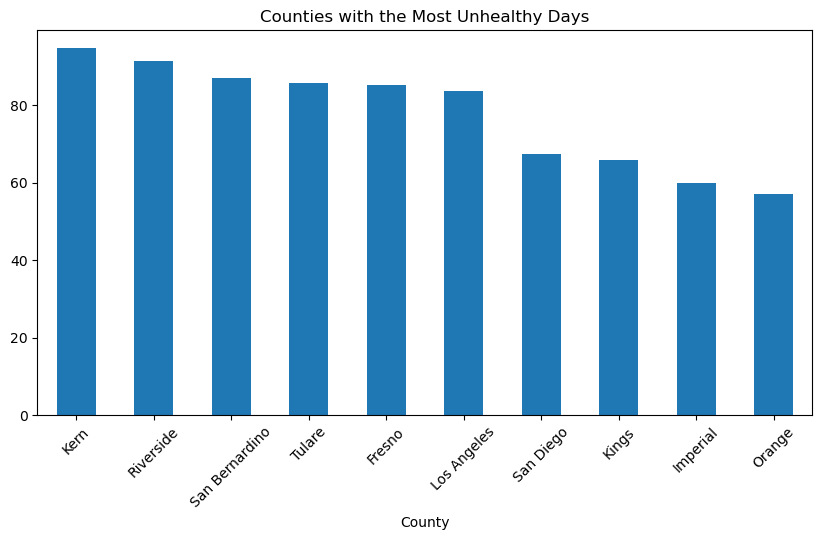

In [ ]:
# counties with the most unhealthy days
counties_worst_air_qual = ca_df.groupby('County')['Median AQI'].mean().sort_values(ascending=False).head(10)

counties_worst_air_qual.plot(kind='bar', figsize=(10, 5), title='Counties with the Most Unhealthy Days')
plt.xticks(rotation=45);

# Monthly AQI Data For Worst Cities

In [ ]:
# a separate df for each county with the worst air quality
los_angeles = ca_df_daily.query('`county Name` == "Los Angeles"').copy()
Kern = ca_df_daily.query('`county Name` == "Kern"').copy()
San_Bernardino = ca_df_daily.query('`county Name` == "San Bernardino"').copy()
Riverside = ca_df_daily.query('`county Name` == "Riverside"').copy()
Tulare = ca_df_daily.query('`county Name` == "Tulare"').copy()
Fresno = ca_df_daily.query('`county Name` == "Fresno"').copy()
Kings = ca_df_daily.query('`county Name` == "Kings"').copy()
Imperial = ca_df_daily.query('`county Name` == "Imperial"').copy()
Orange = ca_df_daily.query('`county Name` == "Orange"').copy()
San_Diego = ca_df_daily.query('`county Name` == "San Diego"').copy()

# daily to monthly
los_angeles = los_angeles.resample('MS').mean()
# merge with mortality data

Kern = Kern.resample('MS').mean()
San_Bernardino = San_Bernardino.resample('MS').mean()
Riverside = Riverside.resample('MS').mean()
Tulare = Tulare.resample('MS').mean()
Fresno = Fresno.resample('MS').mean()
Kings = Kings.resample('MS').mean()
Imperial = Imperial.resample('MS').mean()
Orange = Orange.resample('MS').mean()
San_Diego = San_Diego.resample('MS').mean()


In [ ]:
los_angeles

,County Code,AQI,Number of Sites Reporting
Date,,,
1999-01-01,37.0,104.709677,14.000000
1999-02-01,37.0,90.214286,14.000000
1999-03-01,37.0,69.612903,14.000000
1999-04-01,37.0,75.233333,14.000000
1999-05-01,37.0,78.935484,14.000000
...,...,...,...
2022-03-01,37.0,59.516129,16.096774
2022-04-01,37.0,72.166667,16.233333
2022-05-01,37.0,88.225806,15.193548


In [ ]:
def plot_air_quality_by_county(county, air_qual, diseases):
    """
    Plots the number of deaths from a specified set of diseases in a given county, 
    and the amount of specified air quality days in that county, on separate subplots.
    
    Args:
        county (str): The name of the county to plot data for.
        air_qual (str): The type of air quality to plot data for.
        diseases (list): A list of strings representing the names of the diseases to plot data for.
    """
    # create figure and subplots
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # query mortality df
    mortality.query(f'County == "{county}" and Strata == "Total Population" and Cause in {diseases}').groupby('Year')['Count'].sum().plot(kind='line', figsize=(10, 5), title=f'Deaths from {diseases} in {county} by Year', ax=ax[0])
    

    # overlay line plot of unhealthy days from ca_df log scale
    ca_df.query(f'County == "{county}"').groupby('Year')[air_qual].sum().plot(kind='line', figsize=(10, 5), title=f'{air_qual} in {county} by Year', ax=ax[1], color='red')

    # tight layout
    plt.tight_layout()
    
    # close figure
    plt.show()
    plt.close()

# function to plot correlation matrix for air quality and disease df
def get_correlation_plot(df, title):
    """
    Plots the upper triangle of the correlation matrix for a given dataframe.
    
    Args:
        df (pd.DataFrame): The dataframe to plot the correlation matrix for.
    """
    # create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # plot heatmap
    sns.heatmap(df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=np.triu(df, k=1), ax=ax)
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    # tight layout
    plt.tight_layout()
    
    # close figure
    plt.show()
    plt.close()


# Granger Causality Tests

In [510]:
from statsmodels.tsa.stattools import grangercausalitytests

# Perform the Granger causality test
maxlag = 2 # number of lags to consider

# Null hypothesis: x does not Granger cause y
# Alternative hypothesis: x Granger causes y

def air_qual_test(df, air_qual_stat):
    for county in counties_worst_air_qual.index:
        try:
            # perform granger causality test
            result = grangercausalitytests(df.query(f'County == "{county}"')[['Count', air_qual_stat]], maxlag=maxlag, verbose=False)
            # get lag 1 p values
            lag1 = np.array([result[1][0][key][1] for key in result[1][0].keys()]).mean()
            # get lag 2 p values
            lag2 = np.array([result[2][0][key][1] for key in result[1][0].keys()]).mean()
            # alpha = 0.05 
            if lag1 < 0.05:
                print(f'Air Quality metric: ({air_qual_stat}) Granger causes deaths from cancerous diseases in {county} county with p_value of {lag1} and lag of 1')
                return county, air_qual_stat, lag1, 1, df['Cause'].unique()[0]
            elif lag2 < 0.05:
                print(f'Air Quality metric: ({air_qual_stat}) Granger causes deaths from cancerous diseases in {county} county with p_value of {lag2} and lag of 2')
                return county, air_qual_stat, lag2, 2, df['Cause'].unique()[0]
            else:
                pass
        except:
            print('Air quality metric not in dataset.')

counties = []
# test for each air quality stat
    # add dicts to counties dict
for df in [cld, can, pneumonia, heart_disease]:
    for air_qual_stat in ['Days PM2.5', 'Days NO2', 'Days Ozone', 'Days PM10', 'Unhealthy Days', 'Median AQI']:
        counties.append(air_qual_test(df, air_qual_stat))
        

granger_df = pd.DataFrame(counties, columns=['County','air_qual_metric','p_value', 'lag', 'Cause'])

granger_df.sort_values(by='County', ascending=True, inplace=True)

granger_df.dropna(inplace=True)
granger_df

Air Quality metric: (Days PM2.5) Granger causes deaths from cancerous diseases in San Bernardino county with p_value of 0.031085038233294383 and lag of 1
Air Quality metric: (Days NO2) Granger causes deaths from cancerous diseases in Kern county with p_value of 0.02326467298395096 and lag of 1
Air Quality metric: (Days PM10) Granger causes deaths from cancerous diseases in Riverside county with p_value of 0.04112011440054087 and lag of 1
Air Quality metric: (Unhealthy Days) Granger causes deaths from cancerous diseases in San Bernardino county with p_value of 0.010429616891486249 and lag of 1
Air Quality metric: (Median AQI) Granger causes deaths from cancerous diseases in San Diego county with p_value of 0.011725205909490083 and lag of 2
Air Quality metric: (Days PM2.5) Granger causes deaths from cancerous diseases in Los Angeles county with p_value of 0.0037490376870667587 and lag of 1
Air Quality metric: (Days NO2) Granger causes deaths from cancerous diseases in Kern county with p_

,County,air_qual_metric,p_value,lag,Cause
19,Imperial,Days NO2,0.013743,1.0,HTD
1,Kern,Days NO2,0.023265,1.0,CLD
18,Kern,Days PM2.5,0.006126,2.0,HTD
7,Kern,Days NO2,0.008690,1.0,CAN
17,Kern,Median AQI,0.021730,1.0,PNF
10,Kern,Unhealthy Days,0.004728,1.0,CAN
20,Kern,Days Ozone,0.018678,2.0,HTD
16,Kern,Unhealthy Days,0.003019,1.0,PNF
13,Kern,Days NO2,0.020468,1.0,PNF
6,Los Angeles,Days PM2.5,0.003749,1.0,CAN


# Correlation Plots

In [ ]:
# numeric columns in ca_df
numeric_cols = ['Good Days', 'Moderate Days', 'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI', 'Days CO', 'Days NO2', 'Days Ozone', 'Days PM2.5', 'Days PM10', 'Days with AQI', 'Count', 'Median AQI']

# query for worst counties for each disease
cld_corr = cld.query('County in @counties_worst_air_qual.index')[numeric_cols].corr()

can_corr = can.query('County in @counties_worst_air_qual.index')[numeric_cols].corr()

pneumonia_corr = pneumonia.query('County in @counties_worst_air_qual.index')[numeric_cols].corr()

heart_disease_corr = heart_disease.query('County in @counties_worst_air_qual.index')[numeric_cols].corr()


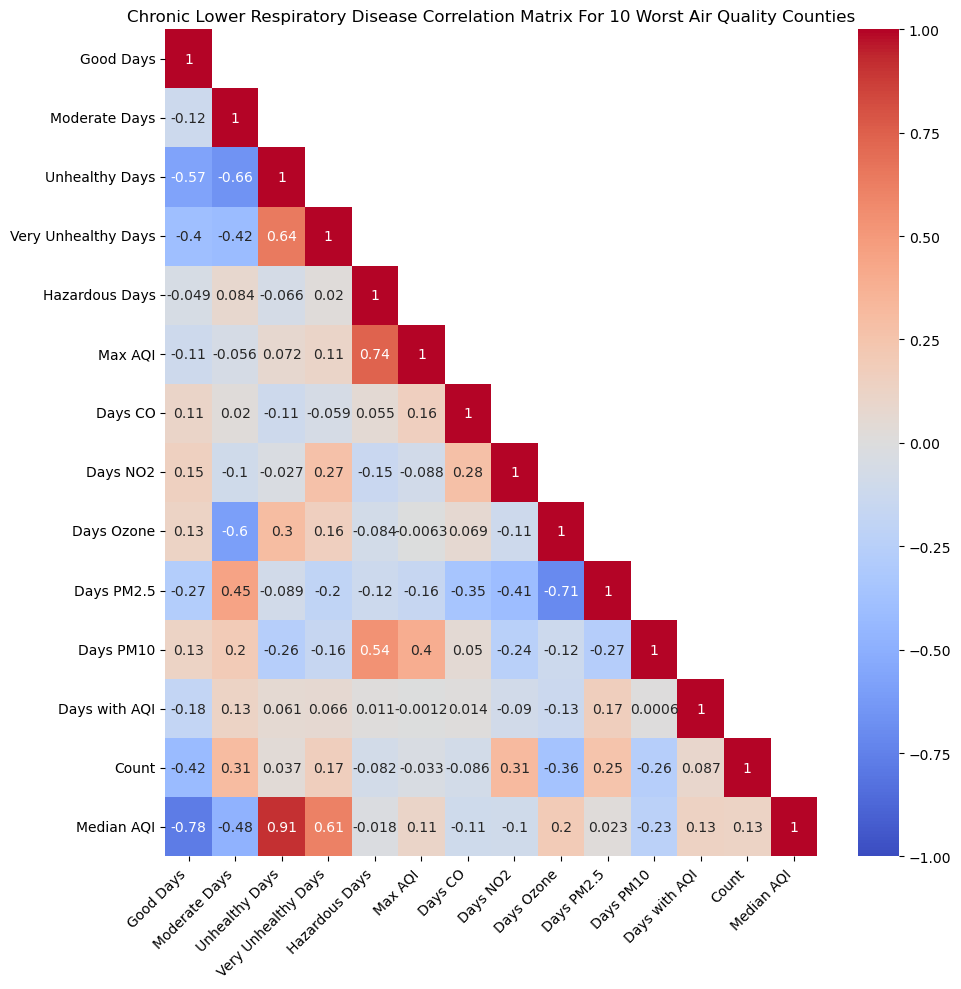

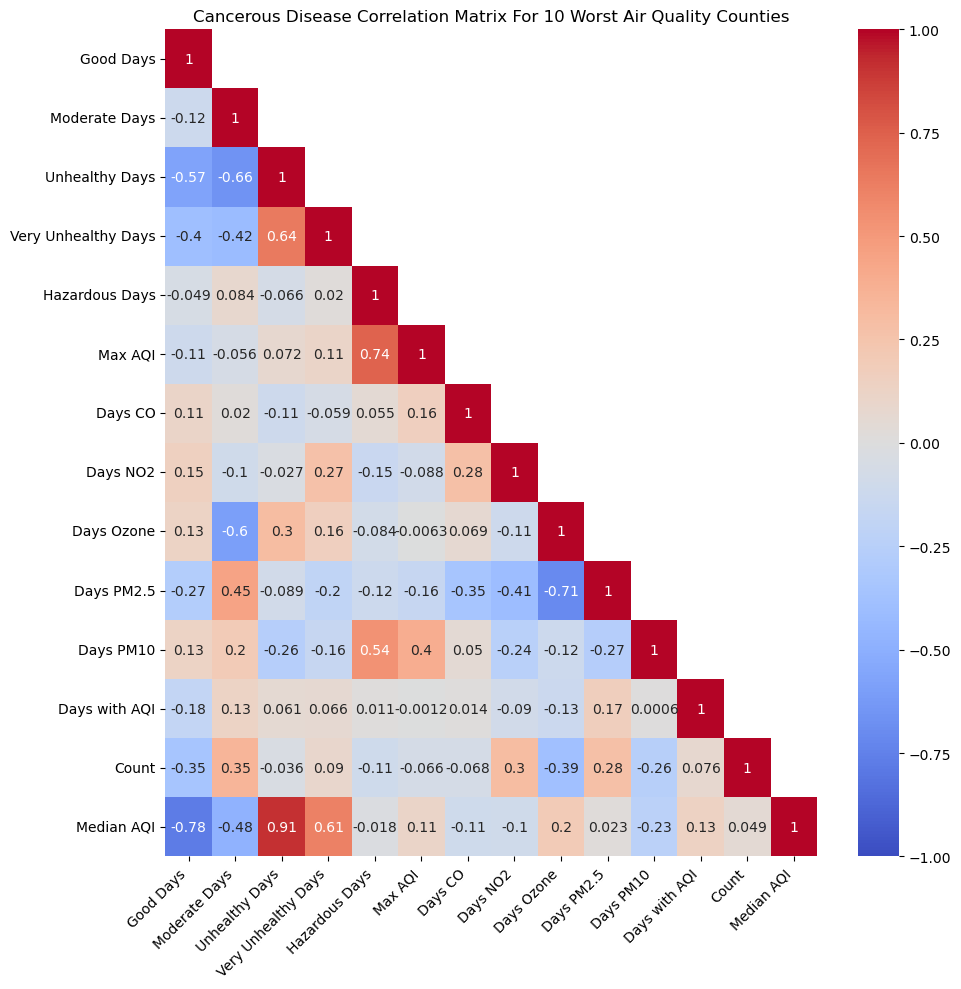

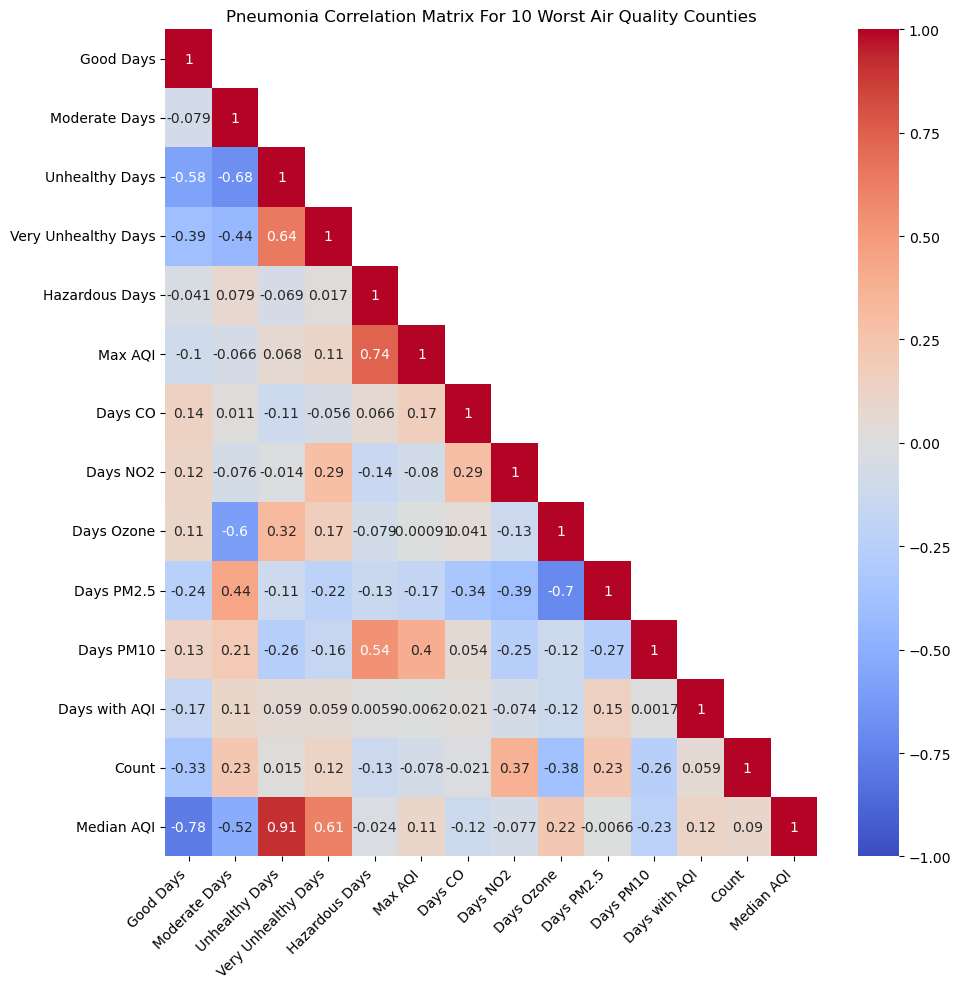

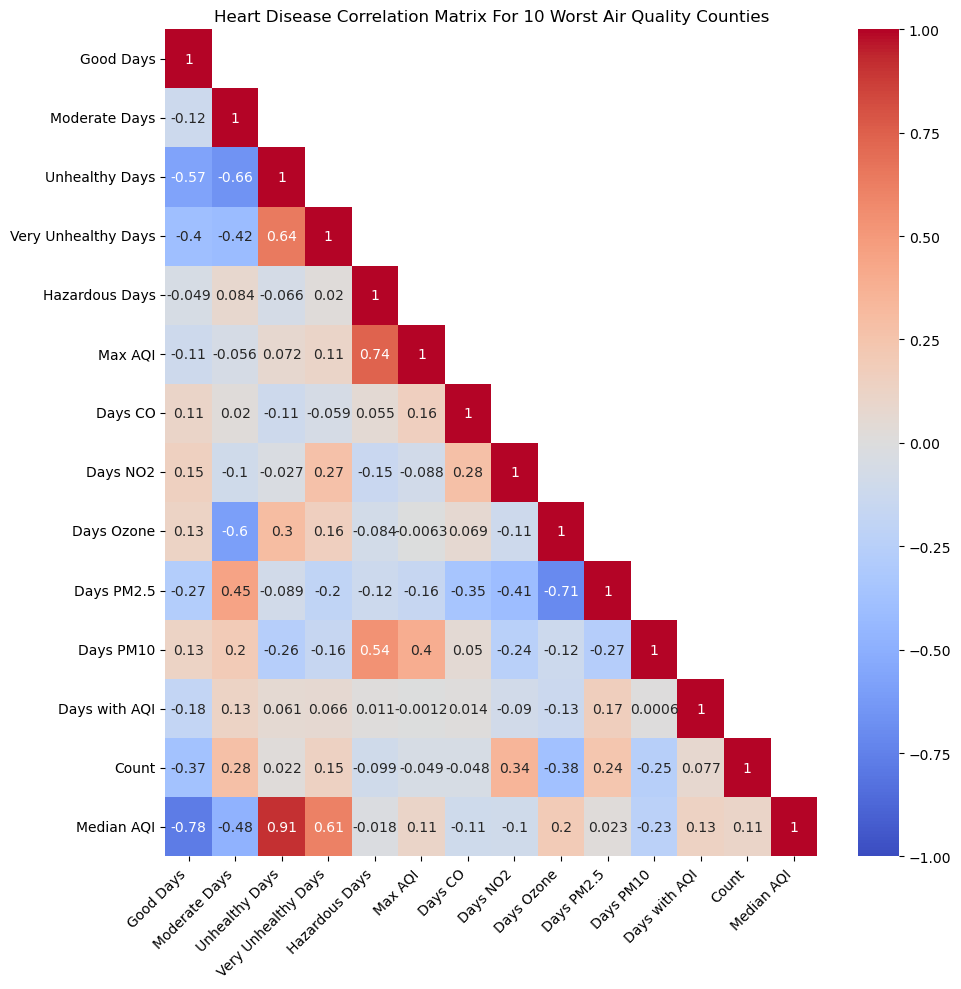

In [ ]:
# CLD
get_correlation_plot(cld_corr, 'Chronic Lower Respiratory Disease Correlation Matrix For 10 Worst Air Quality Counties')

# CAN
get_correlation_plot(can_corr, 'Cancerous Disease Correlation Matrix For 10 Worst Air Quality Counties')

# PNF
get_correlation_plot(pneumonia_corr, 'Pneumonia Correlation Matrix For 10 Worst Air Quality Counties')

# HTD
get_correlation_plot(heart_disease_corr, 'Heart Disease Correlation Matrix For 10 Worst Air Quality Counties')

# Line Plots

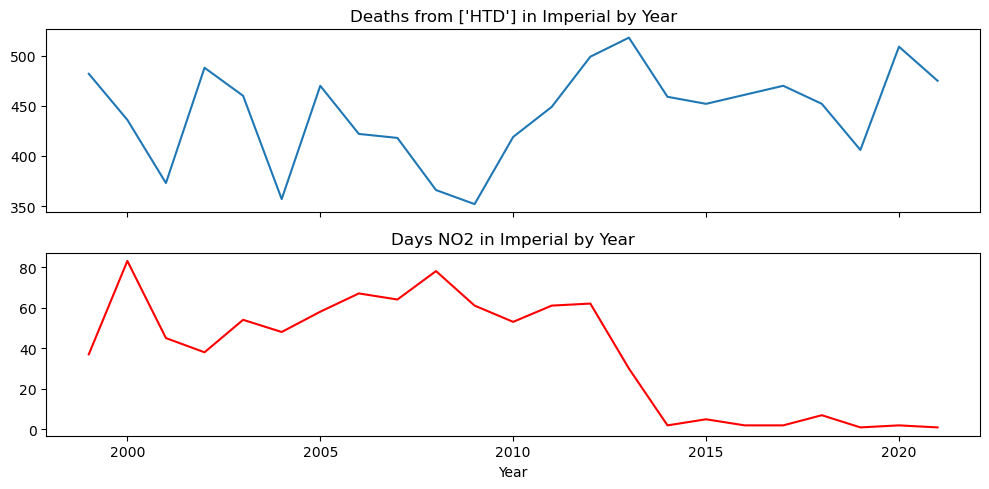

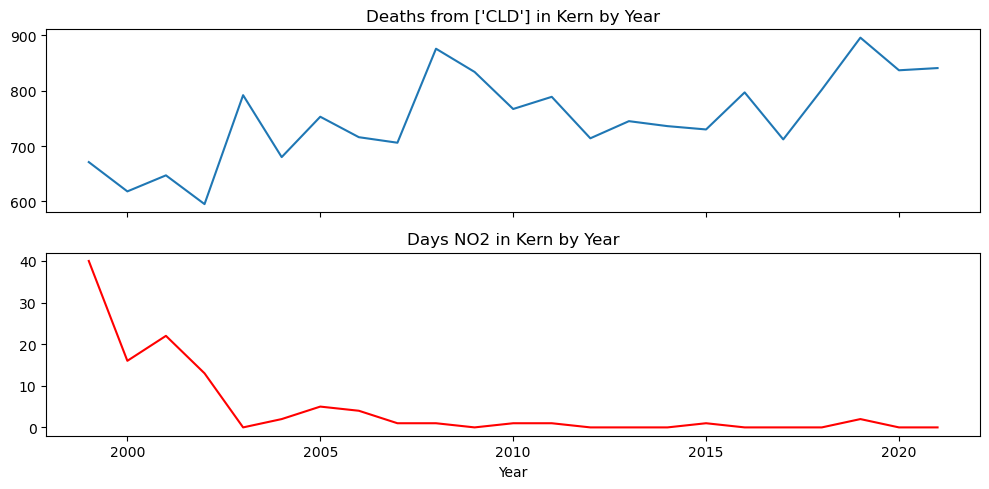

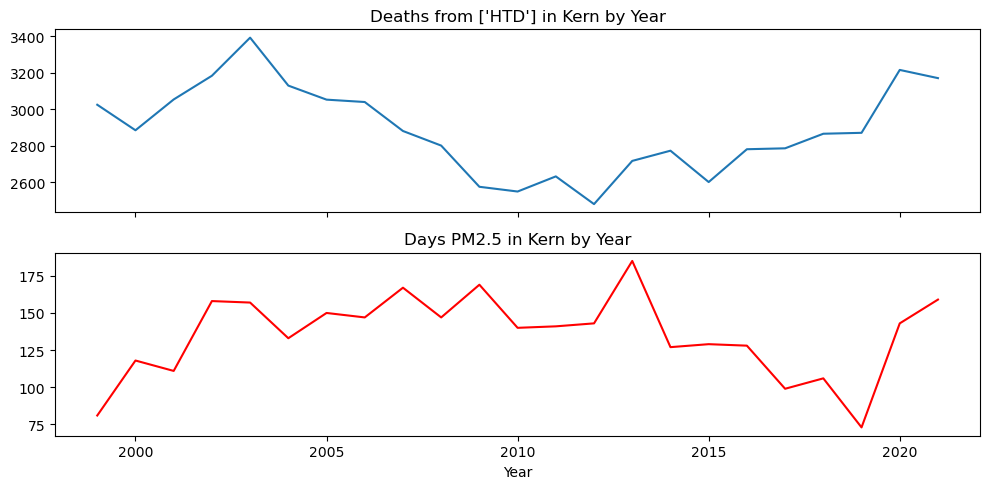

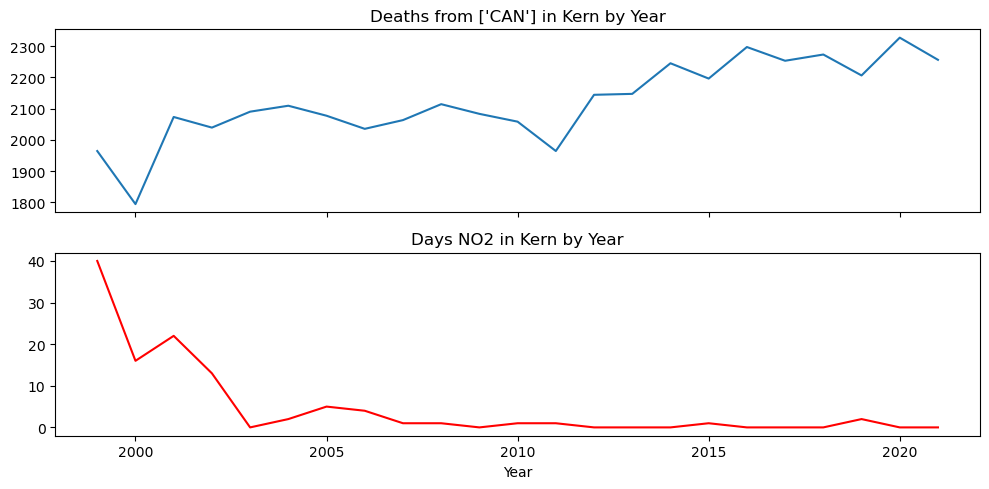

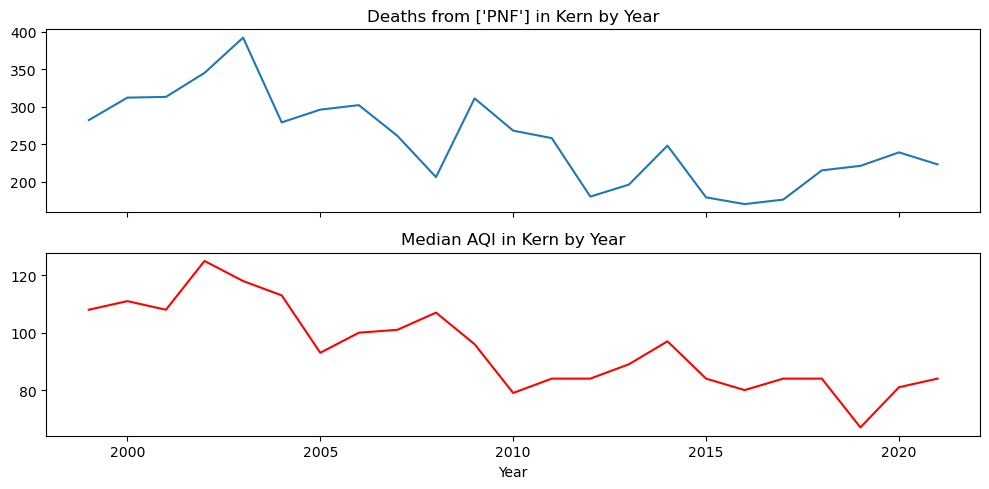

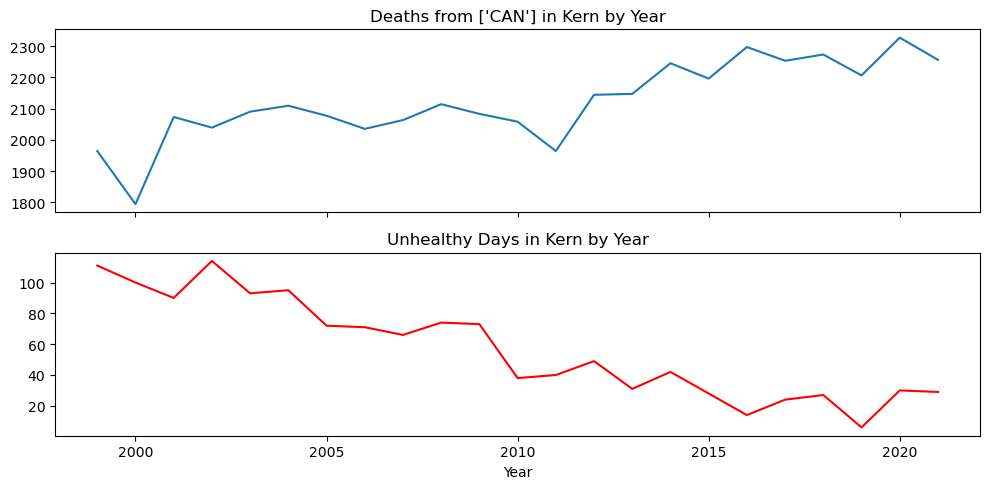

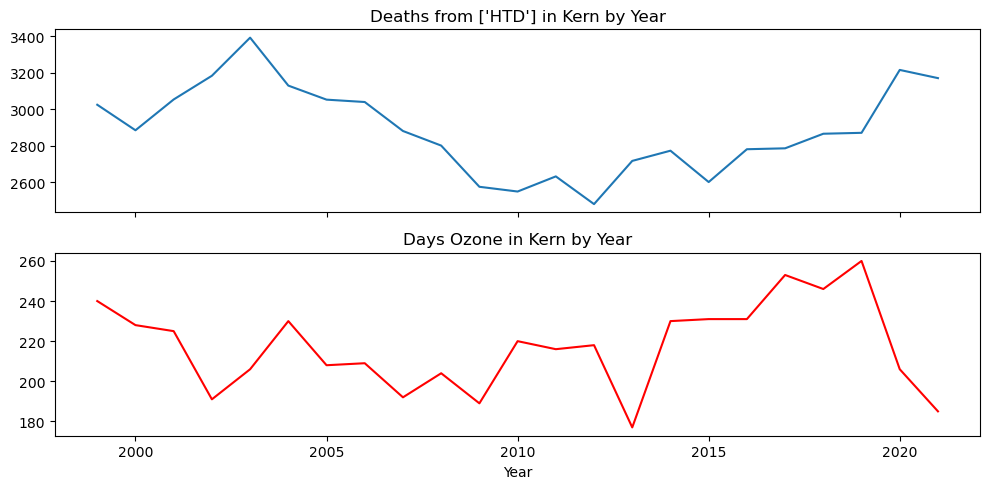

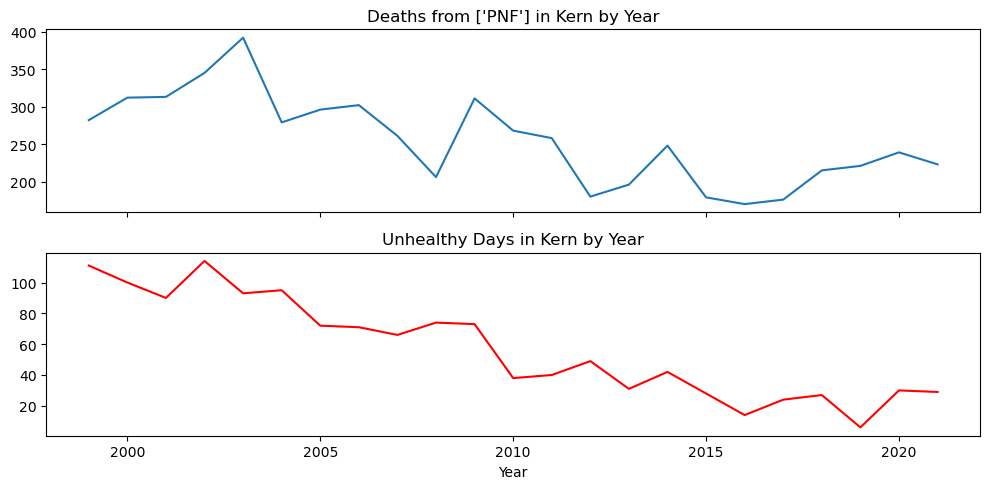

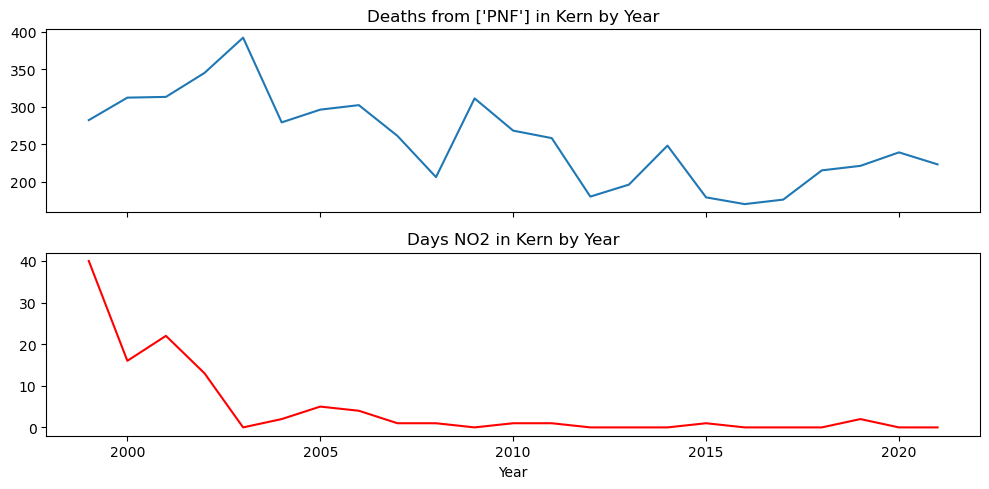

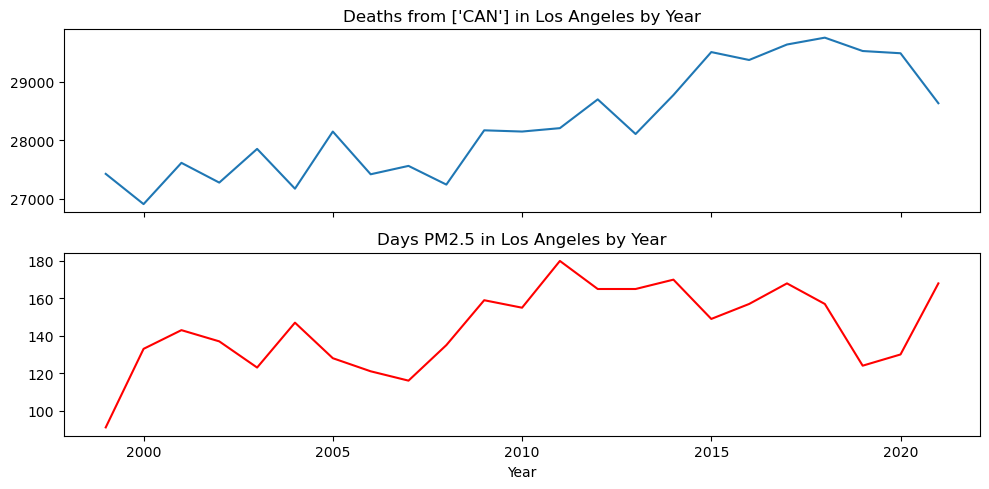

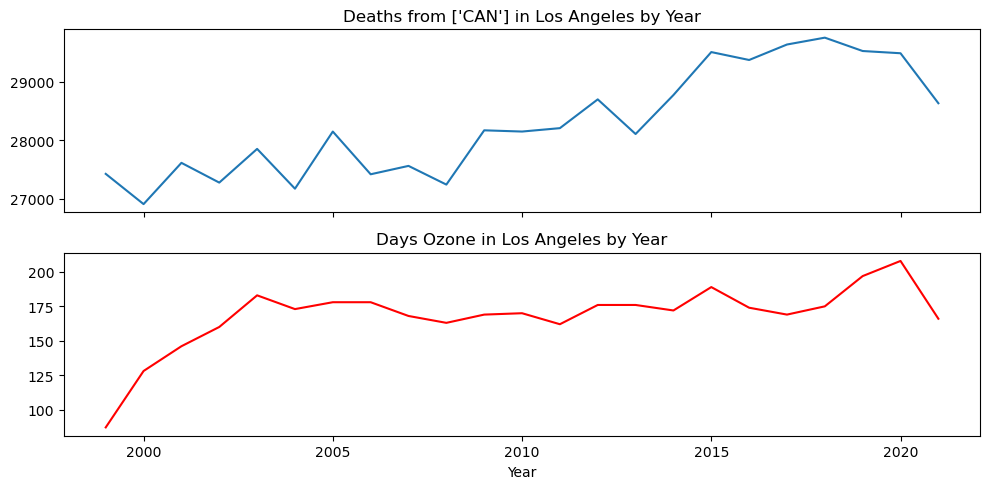

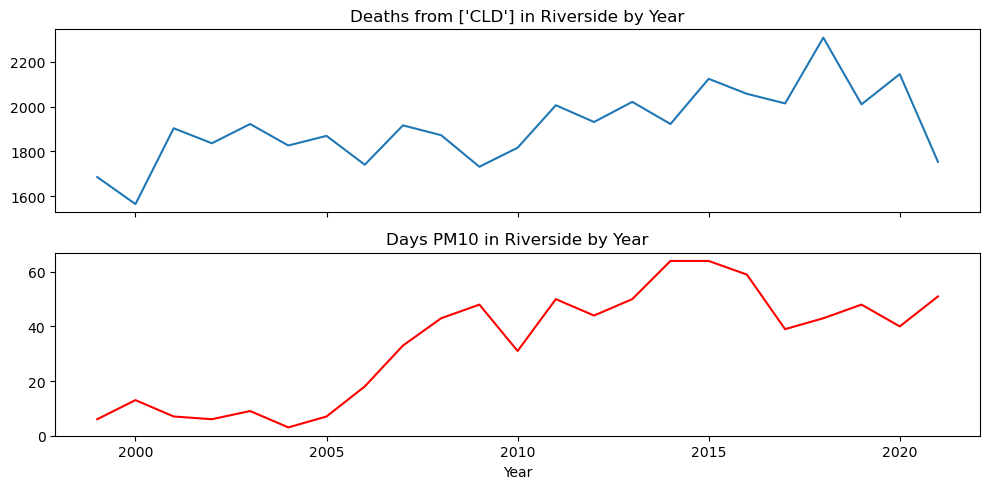

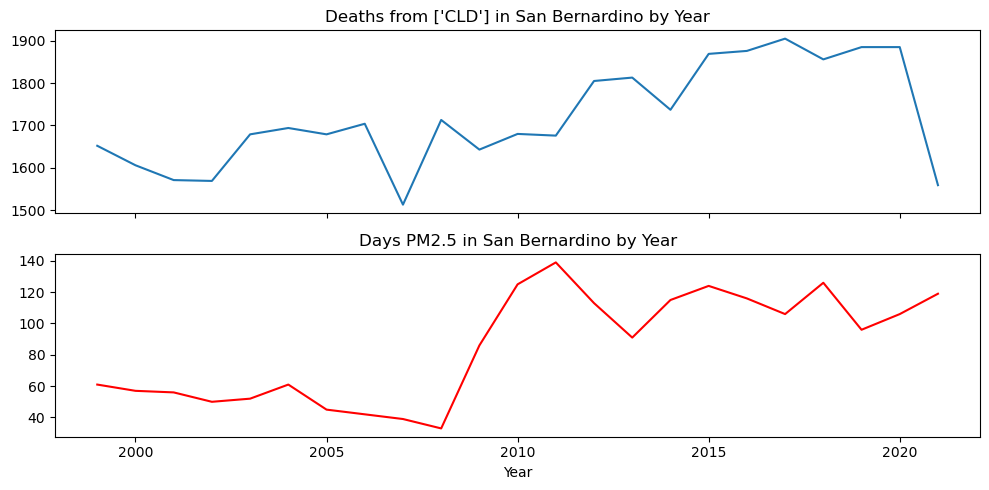

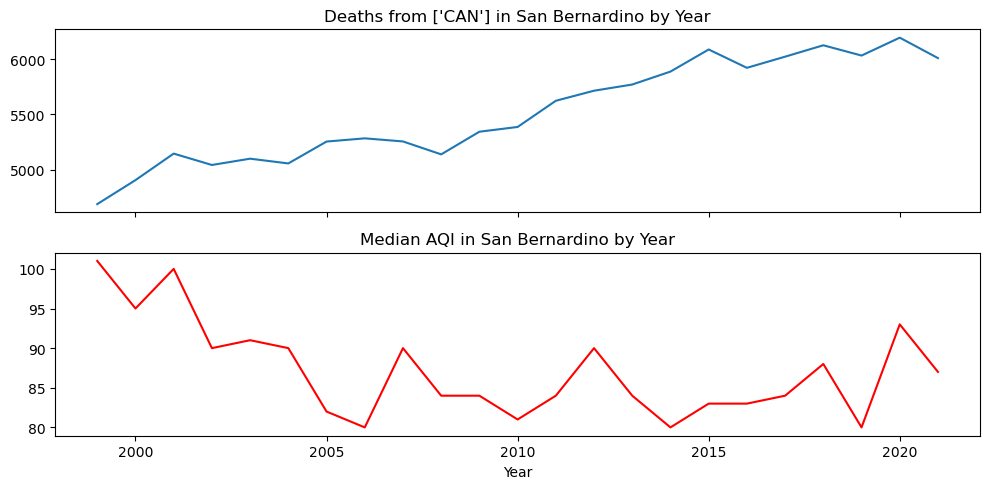

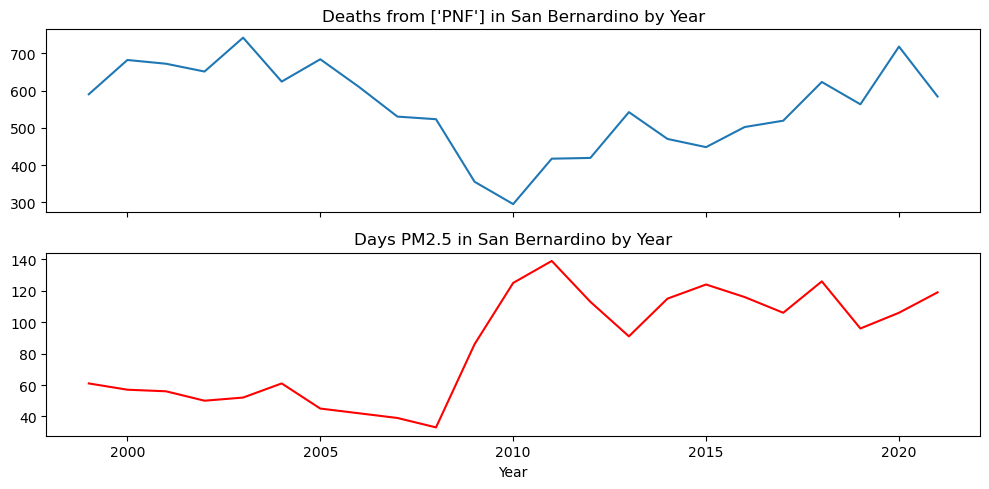

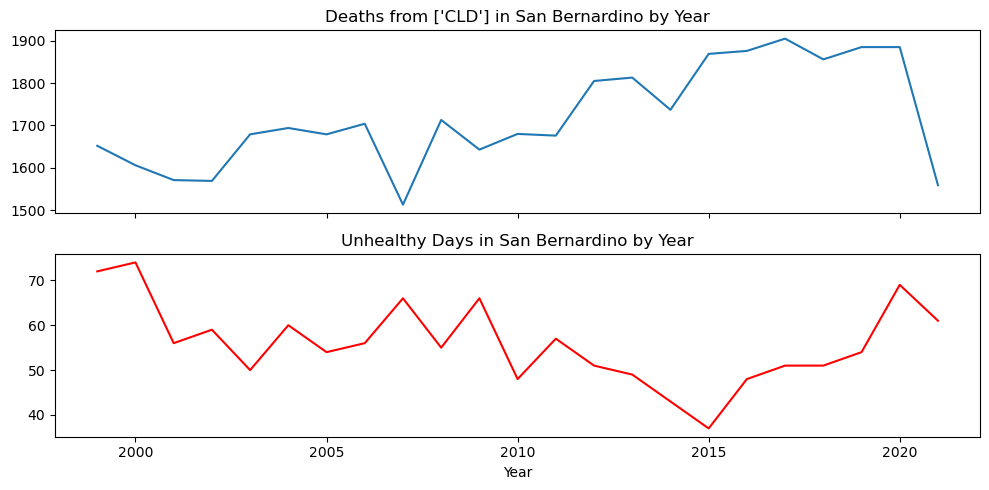

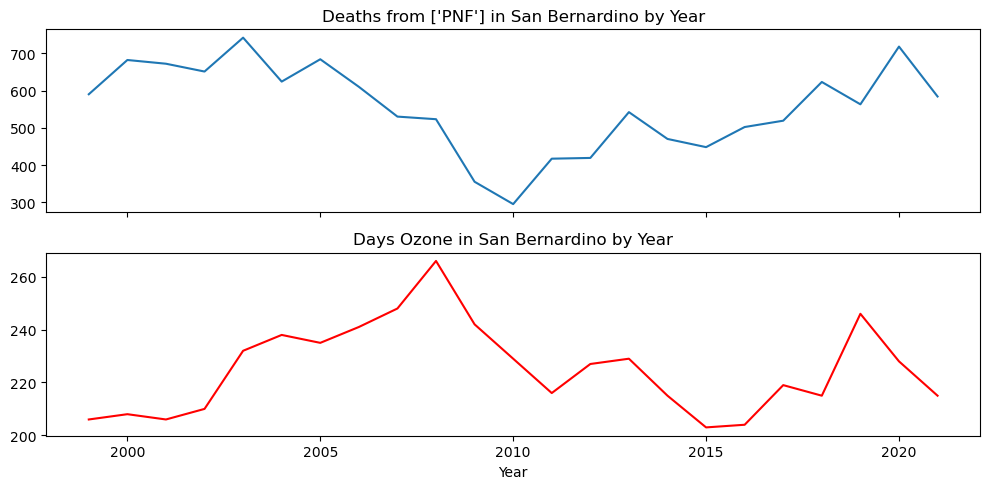

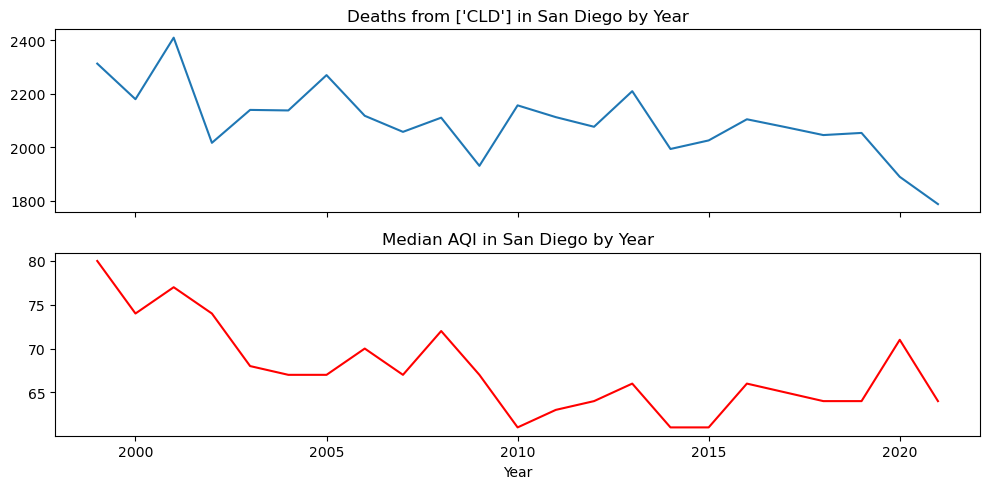

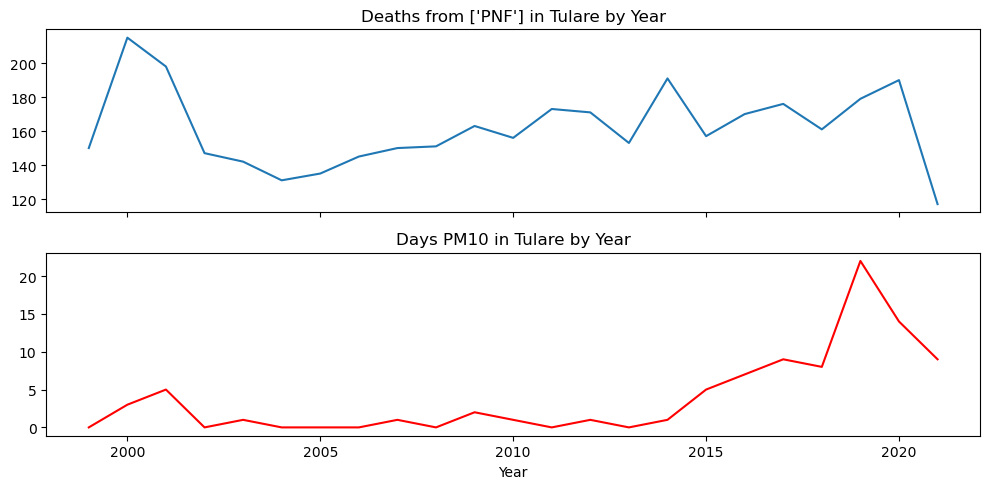

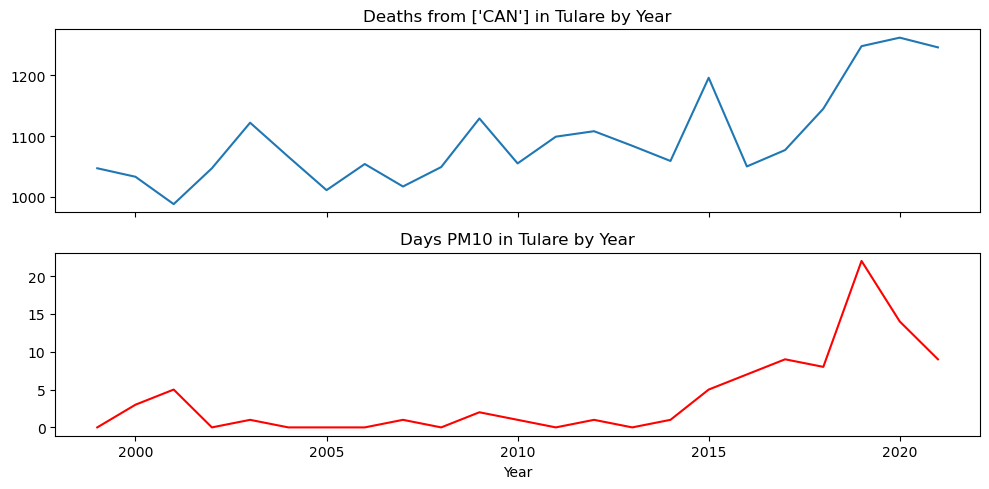

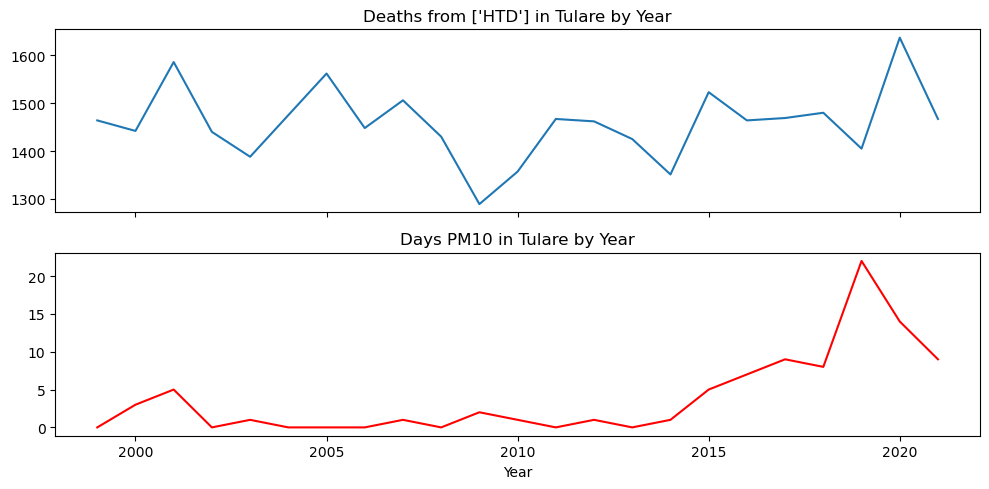

In [ ]:
for county in granger_df.iterrows():
    try:
        plot_air_quality_by_county(county[1]['County'], county[1]['air_qual_metric'], [county[1]['Cause']])
    except:
        pass

# Regression